# Image classification with Azure OpenAI gpt-4o
## Use-case: Flowers dataset

In [1]:
import base64
import glob
import ipyplot
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import seaborn as sns
import sys

from datetime import datetime
from dotenv import load_dotenv
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Azure OpenAI version: {openai.__version__}")

Azure OpenAI version: 1.59.6


In [4]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-22 08:28:11


In [6]:
load_dotenv("azure.env")

aoai_key = os.getenv("api_key")
aoai_endpoint = os.getenv("azure_endpoint")

model = "gpt-4o"  # Azure OpenAI model to use

## Helper

In [7]:
def count_image_files(path):
    """
    Counts and prints the number of image files in each subdirectory of the given directory.

    Args:
        path (str): The path to the directory to search for image files.
    """
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
    nb_images = 0

    for root, dirs, files in os.walk(path):
        dirs[:] = [d for d in dirs if d != '.ipynb_checkpoints']
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            num_image_files = len([f for f in os.listdir(subdir_path) 
                                   if os.path.isfile(os.path.join(subdir_path, f)) and 
                                   os.path.splitext(f)[1].lower() in image_extensions])
            print(f"{subdir_path} | Number of image files = {num_image_files}")
            nb_images += num_image_files

    print(f"\nTotal number of images files = {nb_images}")

In [8]:
def display_image(image_file):
    """
    Display an image file.

    This function checks if the specified image file exists. 
    If the file exists, it opens and displays the image.
    If the file does not exist, it prints an error message.

    Parameters:
    image_file (str): The path to the image file to be displayed.

    Returns:
    None
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(f"Image file to classify: {image_file}")
        img = Image.open(image_file)
        display(img)

In [9]:
def local_image_to_url(image_file):
    """
    Convert a local image file to a data URL.

    This function checks if the specified image file exists. If the file exists, it reads the file,
    encodes its content in base64, and returns a data URL that can be used to embed the image in web pages.
    If the file does not exist, it prints an error message and returns None.
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None
    
    else:
        mime_type, _ = guess_type(image_file)
        if mime_type is None:
            mime_type = 'application/octet-stream'
        with open(image_file, "rb") as imagefile:
            base64_encoded_data = base64.b64encode(
                imagefile.read()).decode('utf-8')
        return f"data:{mime_type};base64,{base64_encoded_data}"

In [10]:
def get_image_classification(image_file, model=model):
    """
    Classify an image using an Azure OpenAI model.

    This function takes an image file and uses an Azure OpenAI model to classify the image.
    It constructs a prompt for the model to analyze the image and return a classification from a 
    predefined list of classes.
    If the model cannot determine the class, it returns 'unknown'.

    Parameters:
    image_file (str): The path to the image file to be classified.
    model (str): The name of the Azure OpenAI model to be used for classification.

    Returns:
    str: The classification result from the model.
    """
    # Azure OpenAI client
    aoai_client = AzureOpenAI(api_key=aoai_key,
                              api_version="2024-10-21",
                              azure_endpoint=aoai_endpoint)

    prompt = f"""
    Analyze the provided image of flowers There are four classes of metal defects in the surface: {class_labels}.
    You must always return only one word value from that list. If you do not know always choose 'unknown'.
    """
    # Results
    response = aoai_client.chat.completions.create(
        model=model,
        messages=[{
            "role": "system",
            "content": "You are a helpful assistant to analyse image."
        }, {
            "role":
            "user",
            "content": [{
                "type": "text",
                "text": prompt
            }, {
                "type": "image_url",
                "image_url": {
                    "url": f"{local_image_to_url(image_file)}"
                }
            }]
        }],
        max_tokens=800,
        temperature=0.,
        top_p=1,
        presence_penalty=1,
    )

    return response.choices[0].message.content

## Image classification

In [11]:
IMAGES_DIR = "flowers_images"

In [12]:
count_image_files(IMAGES_DIR)

flowers_images/class1 | Number of image files = 10
flowers_images/class2 | Number of image files = 10
flowers_images/class3 | Number of image files = 10
flowers_images/class4 | Number of image files = 10

Total number of images files = 40


In [14]:
images = glob.glob(IMAGES_DIR +  '/**/*.*')
labels = [image.split('/')[-2] for image in images]

ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=5, img_width=170)

In [15]:
class_id = ["class1", "class2", "class3", "class4"]
class_labels = ["dandelion", "rose", "sunflower", "daisy"]

df_classes = pd.DataFrame({"class_id": class_id, "class_labels": class_labels})
df_classes

,class_id,class_labels
0,class1,dandelion
1,class2,rose
2,class3,sunflower
3,class4,daisy


### Tests

Image file to classify: flowers_images/class1/dandelion (1).jpg


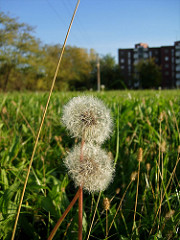

True class: dandelion
Predicted class: dandelion
Prediction is CORRECT


In [16]:
image_file = os.path.join(IMAGES_DIR, "class1/dandelion (1).jpg")

display_image(image_file)

prediction = get_image_classification(image_file)
true_class_id = image_file.split('/')[1]
true_class = df_classes.loc[df_classes['class_id'] == true_class_id,
                            'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction ==
      true_class else "Prediction is INCORRECT")

Image file to classify: flowers_images/class2/rose (1).jpg


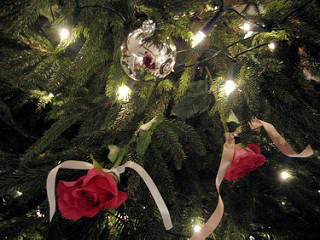

True class: rose
Predicted class: rose
Prediction is CORRECT


In [17]:
image_file = os.path.join(IMAGES_DIR, "class2/rose (1).jpg")

display_image(image_file)

prediction = get_image_classification(image_file)
true_class_id = image_file.split('/')[1]
true_class = df_classes.loc[df_classes['class_id'] == true_class_id,
                            'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction ==
      true_class else "Prediction is INCORRECT")

Image file to classify: flowers_images/class3/sunflower (1).jpg


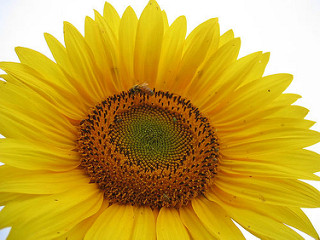

True class: sunflower
Predicted class: sunflower
Prediction is CORRECT


In [18]:
image_file = os.path.join(IMAGES_DIR, "class3/sunflower (1).jpg")

display_image(image_file)

prediction = get_image_classification(image_file)
true_class_id = image_file.split('/')[1]
true_class = df_classes.loc[df_classes['class_id'] == true_class_id,
                            'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction ==
      true_class else "Prediction is INCORRECT")

Image file to classify: flowers_images/class4/daisy (1).jpg


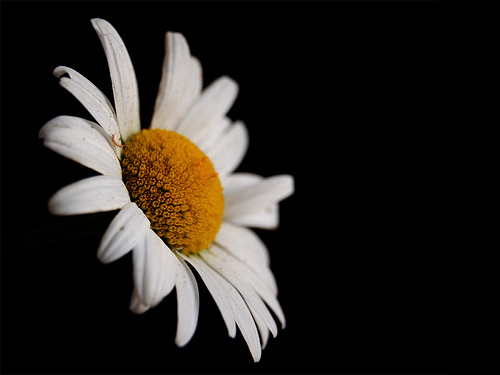

True class: daisy
Predicted class: daisy
Prediction is CORRECT


In [19]:
image_file = os.path.join(IMAGES_DIR, "class4/daisy (1).jpg")

display_image(image_file)

prediction = get_image_classification(image_file)
true_class_id = image_file.split('/')[1]
true_class = df_classes.loc[df_classes['class_id'] == true_class_id,
                            'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction ==
      true_class else "Prediction is INCORRECT")

## Confusion matrix

In [20]:
results = []
idx = 1

for root, dirs, files in os.walk(IMAGES_DIR):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            # True label
            true_labels = df_classes.loc[df_classes['class_id'] ==
                                         os.path.basename(root),
                                         'class_labels'].values[0]
            # Predicted label with GPT-4o
            predicted_labels = get_image_classification(file_path)
            print(
                f"{idx:3} {file_path:50} True label = {true_labels:15} Predicted label = {predicted_labels}"
            )
            results.append({
                "filename": file,
                "true_labels": true_labels,
                "predicted_labels": predicted_labels
            })
            idx += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

  1 flowers_images/class1/dandelion (1).jpg            True label = dandelion       Predicted label = dandelion
  2 flowers_images/class1/dandelion (10).jpg           True label = dandelion       Predicted label = dandelion
  3 flowers_images/class1/dandelion (2).jpg            True label = dandelion       Predicted label = dandelion
  4 flowers_images/class1/dandelion (3).jpg            True label = dandelion       Predicted label = dandelion
  5 flowers_images/class1/dandelion (4).jpg            True label = dandelion       Predicted label = dandelion
  6 flowers_images/class1/dandelion (5).jpg            True label = dandelion       Predicted label = dandelion
  7 flowers_images/class1/dandelion (6).jpg            True label = dandelion       Predicted label = dandelion
  8 flowers_images/class1/dandelion (7).jpg            True label = dandelion       Predicted label = dandelion
  9 flowers_images/class1/dandelion (8).jpg            True label = dandelion       Predicted label = da

In [21]:
print(f"Total of processed images = {idx-1}")

Total of processed images = 40


In [22]:
df = pd.DataFrame(results)
df

,filename,true_labels,predicted_labels
0,dandelion (1).jpg,dandelion,dandelion
1,dandelion (10).jpg,dandelion,dandelion
2,dandelion (2).jpg,dandelion,dandelion
3,dandelion (3).jpg,dandelion,dandelion
4,dandelion (4).jpg,dandelion,dandelion
5,dandelion (5).jpg,dandelion,dandelion
6,dandelion (6).jpg,dandelion,dandelion
7,dandelion (7).jpg,dandelion,dandelion
8,dandelion (8).jpg,dandelion,dandelion
9,dandelion (9).jpg,dandelion,dandelion


True label distribution


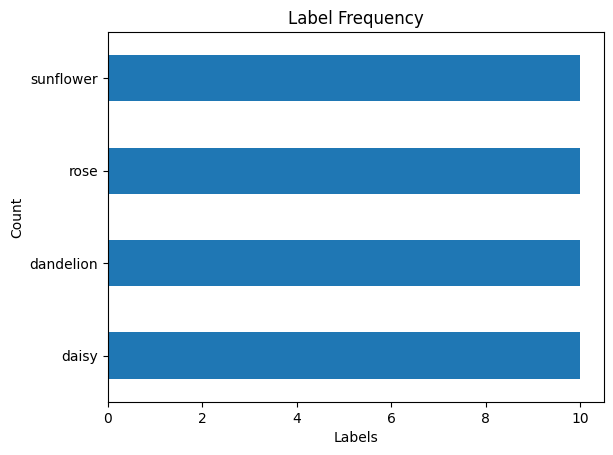

In [23]:
print("True label distribution")

df['true_labels'].value_counts(sort=False).sort_index().plot(kind='barh')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Frequency')
plt.show()

Predicted labels distribution


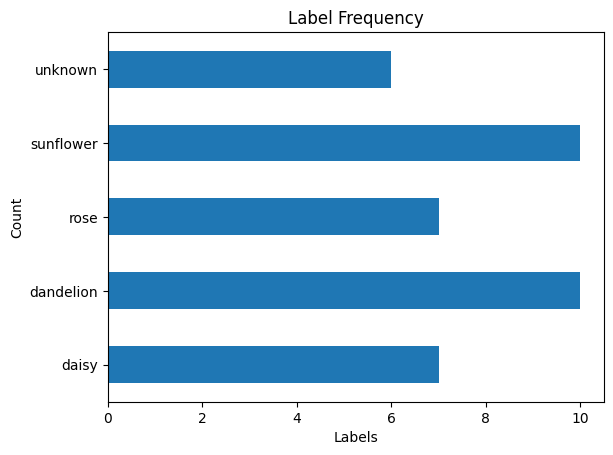

In [24]:
print("Predicted labels distribution")

df['predicted_labels'].value_counts(sort=False).sort_index().plot(kind='barh')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Frequency')
plt.show()

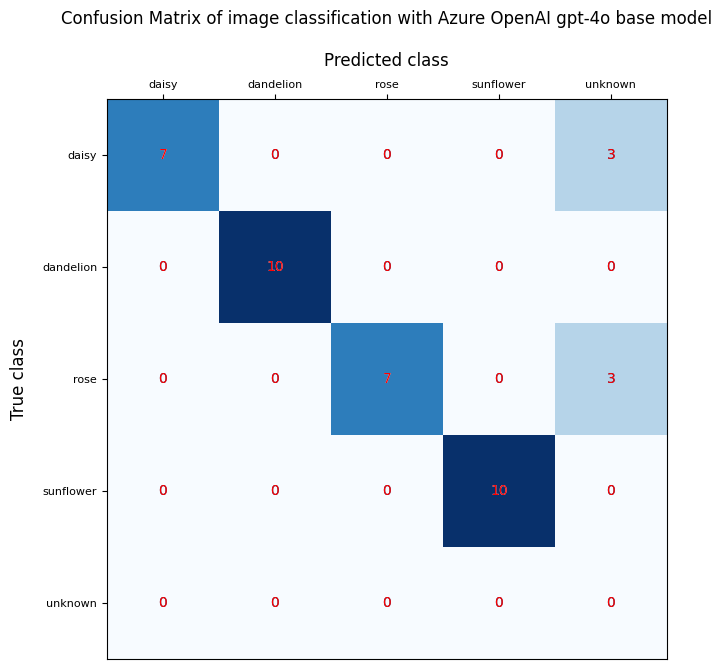

In [25]:
# Convert to numpy arrays
y_true = df[['true_labels']].to_numpy()
y_pred = df[['predicted_labels']].to_numpy()
labels = np.unique(np.concatenate([y_true, y_pred]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j,
            i,
            f"{value}",
            ha="center",
            va="center",
            fontsize=10,
            color="red")

ax.set_title("Confusion Matrix of image classification with Azure OpenAI gpt-4o base model",
             fontsize=12,
             pad=20)

ax.set_xlabel("Predicted class", fontsize=12, labelpad=10)
ax.set_ylabel("True class", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(len(class_labels)), minor=True)
ax.set_yticks(np.arange(len(class_labels)), minor=True)
ax.grid(which="minor", color="black", linestyle="--", linewidth=1)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.15, right=0.85)

plt.show()

In [26]:
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

       daisy       1.00      0.70      0.82        10
   dandelion       1.00      1.00      1.00        10
        rose       1.00      0.70      0.82        10
   sunflower       1.00      1.00      1.00        10
     unknown       0.00      0.00      0.00         0

    accuracy                           0.85        40
   macro avg       0.80      0.68      0.73        40
weighted avg       1.00      0.85      0.91        40



In [27]:
accuracy = np.diag(cm).sum() / cm.sum()
print(f'Accuracy = {accuracy:.2f}')

Accuracy = 0.85


> Azure OpenAI gpt-4o "Zero-shot classification" refers to the ability of a model to correctly classify data it has never seen before, without any specific custom training on that particular type of data. The model is performing reasonably well despite on this kind of usual flower images.